In [1]:
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from train.train_cnn import train_vmc_model
import torch
from physics.j1j2_solver import QuantumJ1J2Solver
from models.cnn import J1J2CNNRegressor1D as CNN
from models.complex_cnn import J1J2ComplexCNNRegressor1D as ComplexCNN
from physics.j1j2_unsupervised import compute_energy_complex_robust, compute_local_energy_log

In [9]:
def run_hyperparameter_grid(model_cls, energy_fn, model_name):
    """
    Runs a grid search over hyperparameters for N=8.
    """
    # 1. Define The Grid
    param_grid = {
        'lr': [0.005],
        'batch_size': [512],
        'mcmc_steps': [10, 50],
        'kernel_size': [2, 3, 5],
        'depth_1': [8, 16, 32], 
        'depth_2': [16, 32, 64]
    }
    
    # Base config for N=8
    base_config = {
        'n_spins': 8,
        'J1': 1.0, 
        'J2': 0.5, # Tune on the frustrated case
        'n_epochs': 50, # Shorter runs for tuning
        'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
    }
    
    # 2. Generate Combinations
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    print(f"--- Starting Grid Search for {model_name} ({len(combinations)} runs) ---")
    
    results = []
    
    for i, params in enumerate(combinations):
        # Merge params into config
        run_config = {**base_config, **params}
        
        try:

            mean_hist, _ = train_vmc_model(model_cls, energy_fn, run_config['J2'], run_config)
            
            final_energy = mean_hist[-1]
            results.append({
                'params': params,
                'final_energy': final_energy,
                'history': mean_hist,
                'label': f"LR:{params['lr']} BS:{params['batch_size']} K:{params['kernel_size']}"
            })
            print(f"[{i+1}/{len(combinations)}] E={final_energy:.4f} | {params}")
            
        except Exception as e:
            print(f"[{i+1}] Failed: {e}")

    return results

In [3]:
def plot_tuning_comparison(results_real, results_complex, exact_energy):
    """
    Plots the top 3 performing configurations for both models.
    """
    # Sort by proximity to exact energy (lowest energy is best for variational)
    results_real.sort(key=lambda x: x['final_energy'])
    results_complex.sort(key=lambda x: x['final_energy'])
    
    top_k = 3
    
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    
    # Plot Real CNN
    axes[0].axhline(exact_energy, color='black', linestyle='--', label=f"Exact ({exact_energy:.4f})")
    for i in range(min(top_k, len(results_real))):
        run = results_real[i]
        axes[0].plot(run['history'], linewidth=2, label=f"{run['label']} (E={run['final_energy']:.3f})")
    axes[0].set_title("Top 3 Real CNN Configs")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Energy")
    axes[0].legend(fontsize='small')
    
    # Plot Complex CNN
    axes[1].axhline(exact_energy, color='black', linestyle='--', label="Exact")
    for i in range(min(top_k, len(results_complex))):
        run = results_complex[i]
        axes[1].plot(run['history'], linewidth=2, label=f"{run['label']} (E={run['final_energy']:.3f})")
    axes[1].set_title("Top 3 Complex CNN Configs")
    axes[1].set_xlabel("Epoch")
    axes[1].legend(fontsize='small')
    
    plt.suptitle("Hyperparameter Tuning Results (N=8, J2=0.5)", fontsize=16)
    plt.tight_layout()
    plt.savefig("tuning_comparison.png")
    plt.show()


========== PART 1: N=8 Hyperparameter Tuning ==========
--- Starting Grid Search for Real CNN (54 runs) ---
Training J1J2CNNRegressor1D...
    Epoch 001 | <E> = -0.9688
    Epoch 025 | <E> = -1.3606
    Epoch 050 | <E> = -2.1020
[1/54] E=-2.1020 | {'lr': 0.005, 'batch_size': 512, 'mcmc_steps': 10, 'kernel_size': 2, 'depth_1': 8, 'depth_2': 16}
Training J1J2CNNRegressor1D...
    Epoch 001 | <E> = -0.9805
    Epoch 025 | <E> = -1.6566
    Epoch 050 | <E> = -2.2883
[2/54] E=-2.2883 | {'lr': 0.005, 'batch_size': 512, 'mcmc_steps': 10, 'kernel_size': 2, 'depth_1': 8, 'depth_2': 32}
Training J1J2CNNRegressor1D...
    Epoch 001 | <E> = -0.9435
    Epoch 025 | <E> = -2.2111
    Epoch 050 | <E> = -2.5263
[3/54] E=-2.5263 | {'lr': 0.005, 'batch_size': 512, 'mcmc_steps': 10, 'kernel_size': 2, 'depth_1': 8, 'depth_2': 64}
Training J1J2CNNRegressor1D...
    Epoch 001 | <E> = -0.9532
    Epoch 025 | <E> = -1.8965
    Epoch 050 | <E> = -2.0219
[4/54] E=-2.0219 | {'lr': 0.005, 'batch_size': 512, 'mcm

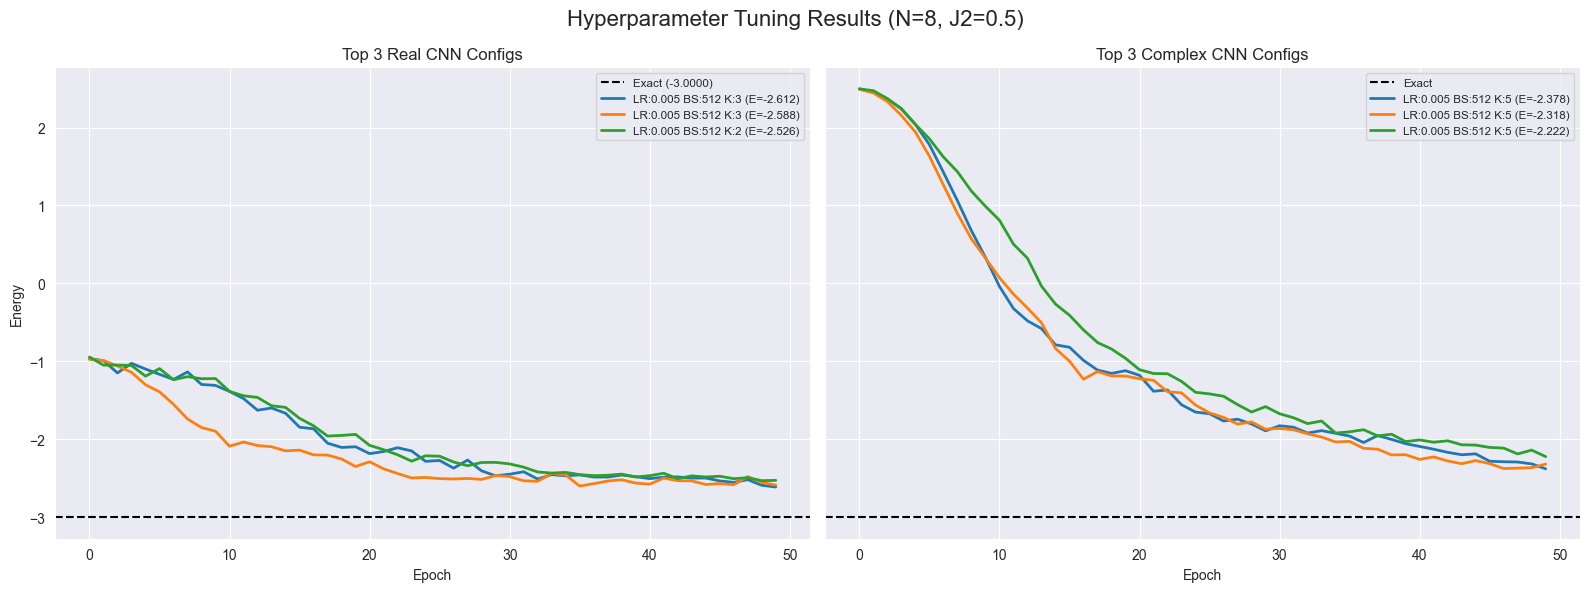

In [10]:
print("\n========== PART 1: N=8 Hyperparameter Tuning ==========")

# 1. Get Baseline for N=8, J2=0.5
solver = QuantumJ1J2Solver(n_spins=8, J1=1.0, J2=0.5)
exact_E_8 = solver.ground_state_energy

# 2. Run Grid Search
# Assuming 'CNN' and 'ComplexCNN' are your defined model classes
# Assuming 'compute_local_energy_log' and 'compute_energy_complex_robust' are your defined loss functions
results_cnn = run_hyperparameter_grid(CNN, compute_local_energy_log, "Real CNN")
results_complex = run_hyperparameter_grid(ComplexCNN, compute_energy_complex_robust, "Complex CNN")

# 3. Plot
plot_tuning_comparison(results_cnn, results_complex, exact_E_8)